Plotting the OSA

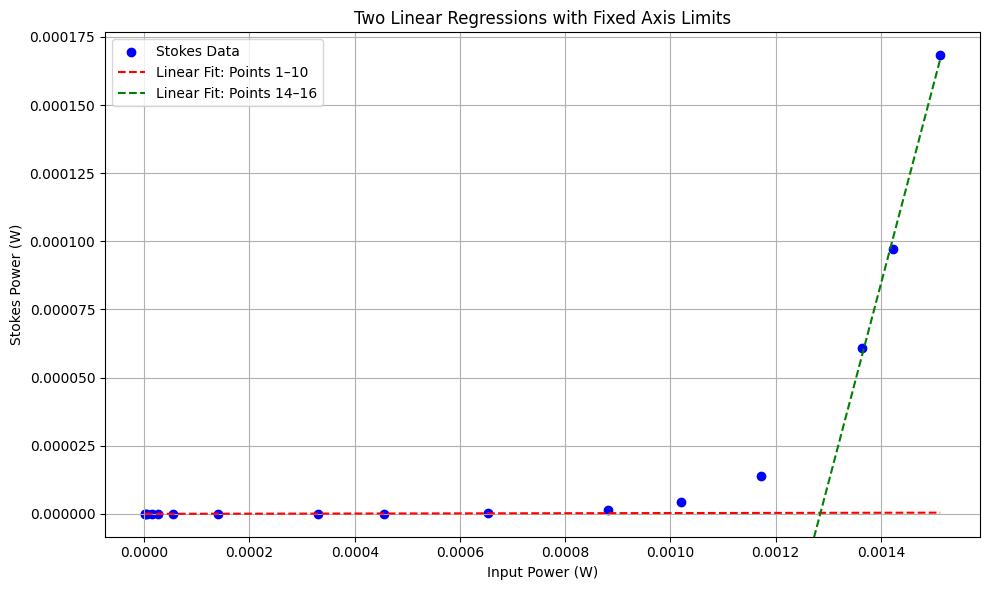

Fit 1 (Points 1–10): y = 2.861e-04x + -1.313e-08
Fit 2 (Points 14–16): y = 7.315e-01x + -9.399e-04


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Raw data
power_uW = np.array([1.03, 2.33, 5.24, 13.95, 25.26, 55.05, 140.4, 330.6,
                     456.6, 653.3, 882, 1021, 1172, 1365, 1423, 1513])
peak_stokes_dBm = np.array([-73.7, -69.9, -66.5, -61.8, -59.42, -55.68, -50.92, -45.14,
                            -41.4, -36.3, -29.16, -23.72, -18.62, -12.16, -10.12, -7.74])

# Convert to watts
power_W = power_uW * 1e-6
stokes_W = 10 ** ((peak_stokes_dBm - 30) / 10)

# Linear regression for points 1–10 (index 0–9)
x1 = power_W[0:10].reshape(-1, 1)
y1 = stokes_W[0:10]
model1 = LinearRegression().fit(x1, y1)

# Linear regression for points 14–16 (index 13–15)
x2 = power_W[13:16].reshape(-1, 1)
y2 = stokes_W[13:16]
model2 = LinearRegression().fit(x2, y2)

# Full x range for "infinite" line appearance
x_range = np.linspace(power_W.min(), power_W.max(), 500).reshape(-1, 1)
y1_line = model1.predict(x_range)
y2_line = model2.predict(x_range)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(power_W, stokes_W, color='blue', label='Stokes Data')
plt.plot(x_range, y1_line, 'r--', label='Linear Fit: Points 1–10')
plt.plot(x_range, y2_line, 'g--', label='Linear Fit: Points 14–16')

# Keep plot limits tight to data only
x_margin = (power_W.max() - power_W.min()) * 0.05
y_margin = (stokes_W.max() - stokes_W.min()) * 0.05
plt.xlim(power_W.min() - x_margin, power_W.max() + x_margin)
plt.ylim(stokes_W.min() - y_margin, stokes_W.max() + y_margin)

plt.xlabel('Input Power (W)')
plt.ylabel('Stokes Power (W)')
plt.title('Two Linear Regressions with Fixed Axis Limits')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print regression equations
print(f"Fit 1 (Points 1–10): y = {model1.coef_[0]:.3e}x + {model1.intercept_:.3e}")
print(f"Fit 2 (Points 14–16): y = {model2.coef_[0]:.3e}x + {model2.intercept_:.3e}")


Plotting the Heterodyne

In [7]:
import pandas as pd
from bokeh.plotting import figure, output_file, save, show

# === Step 1: Read the CSV file ===
csv_path = r"C:\Users\nicoc\Downloads\1235microWatts.csv"  # Replace with your actual path


# Read the file as plain text to find where data begins
with open(csv_path, "r", encoding="utf-8") as file:
    lines = file.readlines()

# === Step 2: Locate the header for the numeric data section ===
start_idx = None
for i, line in enumerate(lines):
    if line.strip().startswith("Frequency") and "Magnitude" in line:
        start_idx = i + 1  # Data starts just after the header
        break

# Check if we found the data section
if start_idx is None:
    raise ValueError("Could not find the data section starting with 'Frequency'.")

# === Step 3: Load only the numerical data using pandas ===
data_text = "".join(lines[start_idx:])
data_io = StringIO(data_text)
df = pd.read_csv(data_io, usecols=[0, 1], names=["Frequency", "Magnitude_dBm"])

# === Step 4: Convert frequencies to MHz for readability ===
df["Frequency_MHz"] = df["Frequency"] / 1e6

from bokeh.models import HoverTool

# === Step 5: Plot with Bokeh ===
output_file("spectrum_plot.html")

p = figure(
    title="Spectrum Analyzer Output",
    x_axis_label="Frequency (MHz)",
    y_axis_label="Magnitude (dBm)",
    plot_width=800,
    plot_height=400,
    tools="pan,wheel_zoom,box_zoom,reset,save"
)

p.line(df["Frequency_MHz"], df["Magnitude_dBm"], line_width=2, color="navy", legend_label="Spectrum")
r = p.circle(df["Frequency_MHz"], df["Magnitude_dBm"], size=6, color="red", legend_label="Data Points")

# Add HoverTool showing frequency and magnitude
hover = HoverTool(tooltips=[
    ("Frequency (MHz)", "@x{0.00}"),
    ("Magnitude (dBm)", "@y{0.00}")
], renderers=[r])

p.add_tools(hover)

p.legend.location = "bottom_left"
p.title.text_font_size = '14pt'

# === Step 6: Output the plot ===
show(p)

Simulating the BGS

Calculated Brillouin frequency: 11151870967.741936 Hz (~ 11.151870967741935 GHz)
Acoustic mode FWHM (Delta_f): 31830988.618379068 Hz (~ 31.830988618379067 MHz)
Overlap integral (scattering coefficient factor g): 30330.426024686538


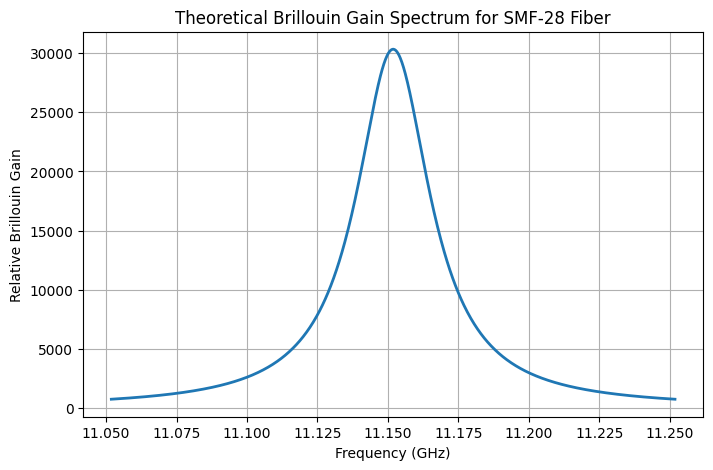

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0  # Bessel function of the first kind, order 0
from scipy.integrate import simps

# -------------------------------
# 1. Define Fiber and Optical Parameters
# -------------------------------

# SMF-28 typical parameters
a = 4.1e-6         # Core radius in meters (4.1 µm)
b = 62.5e-6        # Cladding radius in meters (62.5 µm)
lambda_ = 1.55e-6  # Optical wavelength in meters (1.55 µm)
n_core = 1.455     # Approximate core refractive index
n_clad = 1.444     # Cladding refractive index
w = 5e-6           # Mode-field radius (approximate; SMF-28 typically has a mode-field diameter ~10 µm)

# Optical parameters
c = 3e8   # Speed of light in m/s
omega0 = 2 * np.pi * c / lambda_  # Optical angular frequency (rad/s)

# -------------------------------
# 2. Define Acoustic Parameters
# -------------------------------

# Longitudinal acoustic velocity (typical value for silica)
VL = 5940.0  # [m/s]

# Calculate Brillouin frequency shift: f_B = (2 * n * VL) / lambda
fB = 2 * n_core * VL / lambda_   # [Hz]
print("Calculated Brillouin frequency:", fB, "Hz (~", fB/1e9, "GHz)")

# Acoustic lifetime (T2) sets the linewidth.
# For SMF-28, a typical Brillouin linewidth is tens of MHz.
# Here, we choose T2 = 1e-8 [s] to obtain a linewidth ~ 1/(pi*T2) ≈ 32 MHz.
T2 = 1e-8  # [s]
Delta_f = 1 / (np.pi * T2)  # FWHM of the Lorentzian [Hz]
print("Acoustic mode FWHM (Delta_f):", Delta_f, "Hz (~", Delta_f/1e6, "MHz)")

# -------------------------------
# 3. Set Up the Optical and Acoustic Modes
# -------------------------------

# Create a radial grid for integration (from r=0 to r_max)
r_max = 10e-6   # [m]
Nr = 1000       # Number of radial points
r = np.linspace(0, r_max, Nr)

# Optical mode field (Gaussian approximation of the LP01 mode)
X = np.exp(- (r / w)**2)

# Normalize the optical mode so that the total power is unity:
#   2π ∫|X(r)|² r dr = 1
opt_norm = np.sqrt(2 * np.pi * simps(X**2 * r, r))
X = X / opt_norm

# Acoustic displacement field for the dominant acoustic mode (approximation)
# Here we use a Bessel function form: J0(π r / a)
Yz = j0(np.pi * r / a)

# Optionally, normalize the acoustic field (here we normalize over the radial coordinate)
acoustic_norm = np.sqrt(2 * np.pi * simps(Yz**2 * r, r))
Yz = Yz / acoustic_norm

# -------------------------------
# 4. Compute the Overlap Integral (Scattering Coefficient)
# -------------------------------
#
# The scattering coefficient for an acoustic mode is given by an overlap integral:
#
#    g ∝ ∫_0^∞ |X(r)|² Yz(r) r dr
#
# In the full theory, this integration is multiplied by other constants including the
# elasto-optic coefficient and the acoustic propagation factor. Here, we set those
# parameters to unity for a relative plot.

integrand = X**2 * Yz * r
overlap = 2 * np.pi * simps(integrand, r)
g = overlap  # g represents a relative scattering coefficient
print("Overlap integral (scattering coefficient factor g):", g)

# -------------------------------
# 5. Define the Frequency Axis and Compute the Lorentzian Profile
# -------------------------------

# We define a frequency axis around the Brillouin shift (fB)
freq_min = fB - 100e6  # 100 MHz below fB
freq_max = fB + 100e6  # 100 MHz above fB
Nfreq = 1000
freq = np.linspace(freq_min, freq_max, Nfreq)

# Each acoustic mode contributes a Lorentzian to the total BGS.
# For the dominant mode, the Lorentzian spectral density is given by:
#
#    S(ν) = g / [ 1 + ((ν - fB) / (Delta_f / 2))² ]
#
# with fB the Brillouin shift and Delta_f the FWHM of the spectral line.

S_mode = g / ( 1 + ((freq - fB) / (Delta_f / 2))**2 )

# -------------------------------
# 6. Plot the Theoretical Brillouin Gain Spectrum
# -------------------------------

plt.figure(figsize=(8, 5))
plt.plot(freq / 1e9, S_mode, linewidth=2)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Relative Brillouin Gain")
plt.title("Theoretical Brillouin Gain Spectrum for SMF-28 Fiber")
plt.grid(True)
plt.show()


Fundamental Brillouin frequency fB: 1.12e+10 Hz (~11.15 GHz)
Acoustic linewidth (Delta_f): 3.18e+07 Hz (~31.83 MHz)


C:\Users\nicoc\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in sqrt


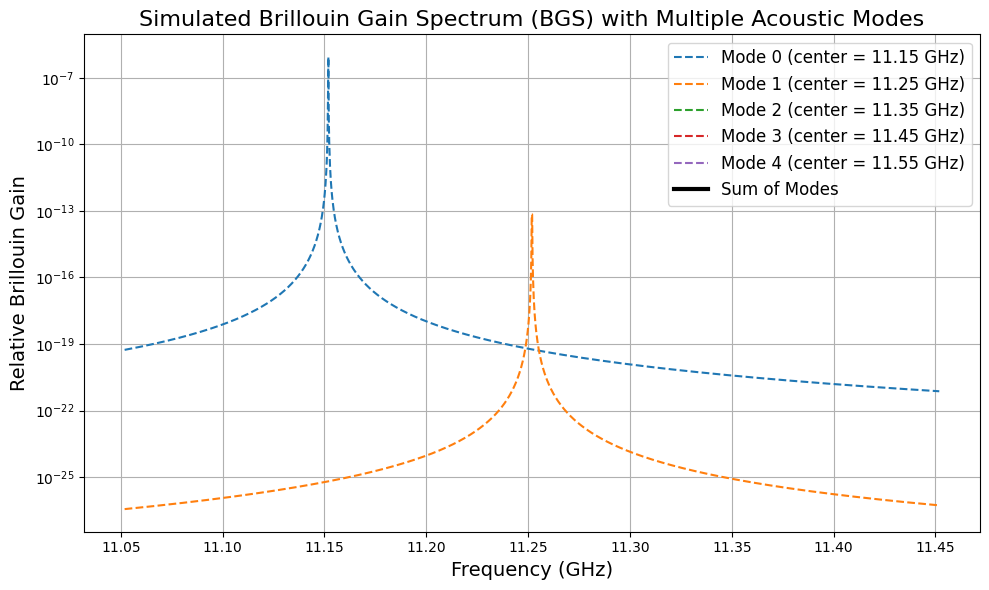

Mode 0: g = 0.000e+00, Center Frequency = 11.152 GHz
Mode 1: g = 0.000e+00, Center Frequency = 11.252 GHz
Mode 2: g = 0.000e+00, Center Frequency = 11.352 GHz
Mode 3: g = 0.000e+00, Center Frequency = 11.452 GHz
Mode 4: g = 0.000e+00, Center Frequency = 11.552 GHz


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0  # zeroth-order Bessel function of the first kind
from scipy.integrate import simps
from scipy.special import jn_zeros  # to find zeros of Bessel functions

# =============================================================================
# 1. Define Fiber and Optical Parameters
# =============================================================================
# SMF-28 typical parameters
a = 4.1e-6         # Core radius in meters (4.1 µm)
b = 62.5e-6        # Cladding radius in meters (62.5 µm)
lambda_ = 1.55e-6  # Optical wavelength in meters (1.55 µm)
n_core = 1.455     # Approximate core refractive index
n_clad = 1.444     # Cladding refractive index  
w = 5e-6           # Mode-field radius in meters (approximation)

# Optical parameters
c = 3e8   # Speed of light in m/s
omega0 = 2 * np.pi * c / lambda_  # Optical angular frequency (rad/s)

# =============================================================================
# 2. Define Acoustic Parameters
# =============================================================================
# Longitudinal acoustic velocity (approximate value for silica)
VL = 5940.0  # [m/s]

# Calculate the fundamental Brillouin frequency shift:
# For the fundamental acoustic mode, fB is given by:
#    fB = 2 * n_core * VL / lambda_
fB = 2 * n_core * VL / lambda_
print("Fundamental Brillouin frequency fB: {:.2e} Hz (~{:.2f} GHz)"
      .format(fB, fB/1e9))

# Acoustic lifetime (T2) sets the linewidth.
# Here we choose T2 = 1e-8 s which gives a FWHM ~ 1/(π*T2).
T2 = 1e-8  # [s]   (means a concentration of GeO2 in the fiber of ~ 10%)
Delta_f = 1 / (np.pi * T2)  # FWHM of the Lorentzian [Hz]
print("Acoustic linewidth (Delta_f): {:.2e} Hz (~{:.2f} MHz)"
      .format(Delta_f, Delta_f/1e6))

# =============================================================================
# 3. Define the Optical Mode and Prepare the Radial Grid
# =============================================================================
# Create a radial grid for integration (from r = 0 to a value beyond the core)
r_max = 10e-6   # [m]
Nr = 1000       # Number of radial points
r = np.linspace(0, r_max, Nr)

# Define the optical LP01 mode (Gaussian approximation)
X = np.exp(- (r / w)**2)

# Normalize the optical field so that:
#    2π ∫|X(r)|² r dr = 1
opt_norm = np.sqrt(2 * np.pi * simps(X**2 * r, r))
X = X / opt_norm

# =============================================================================
# 4. Loop Over Acoustic Mode Orders, Calculate Overlap and Lorentzian Spectrum
# =============================================================================
n_modes = 5  # total number of modes (m=0: fundamental; m=1,2,3: higher orders)

# Pre-allocate arrays to store scattering coefficients and Lorentzian contributions
g_values = np.zeros(n_modes)
mode_centers = np.zeros(n_modes)  # center frequency for each mode
Lorentzian_list = []  # list to store each mode's Lorentzian spectral density

# Define a frequency range for plotting the BGS.
# Here, we choose a span wide enough to include the fundamental plus the additional modes.
freq_min = fB - 100e6
freq_max = fB + 300e6
Nfreq = 2000
freq = np.linspace(freq_min, freq_max, Nfreq)

# For demonstration, we assume that higher-order modes have slightly shifted central frequencies.
# For simplicity, we add a constant offset (here 100 MHz per order) to the fundamental.
delta_center = 100e6  # frequency shift per order (adjust as needed)

# Accumulate the total spectral contribution
S_total = np.zeros_like(freq)

# First 4 zeros of J1 (roots of boundary condition)
mu = jn_zeros(1, n_modes)  # mu_1 to mu_4

Yz_list = []
beta_list = []


for m in range(n_modes):
    mu_m = mu[m]
    # Radial function
    Yz_m = j0(mu_m * r / a)
    
    # Normalize Yz_m over the radial extent:
    ac_norm = np.sqrt(2 * np.pi * simps(Yz_m**2 * r, r))
    Yz_m = Yz_m / ac_norm

    # Propagation constant beta_i
    beta_i = np.sqrt((freq / VL)**2 - (mu_m / a)**2)
    beta_list.append(beta_i)
    
    # Compute the overlap (relative scattering coefficient) for this mode:
    # g_m ∝ ∫ |X|^2 * Yz_m * r dr (with circular symmetry multiplies 2π)
    integrand = X**2 * Yz_m * r
    g_m = 2 * np.pi * simps(integrand, r)*beta_i
    #g_values[m] = g_m

    # Define the center frequency for this mode.
    center_m = fB + m * delta_center
    mode_centers[m] = center_m

    # Compute the Lorentzian spectral density for this mode
    # S_m(ν) = g_m / [ 1 + ((ν - center_m) / (Delta_f/2))² ]
    S_m = (T2*(g_m**2)) / (((freq - center_m)**2 + (T2/ 2))**2)
    Lorentzian_list.append(S_m)
    
    # Sum up the contributions
    S_total += S_m

S_total = S_total*T2

# =============================================================================
# 5. Plot the Individual Contributions and the Total BGS
# =============================================================================
plt.figure(figsize=(10, 6))

# Plot each mode separately
for m in range(n_modes):
    plt.plot(freq/1e9, Lorentzian_list[m],
             label=f"Mode {m} (center = {mode_centers[m]/1e9:.2f} GHz)", lw=1.5, linestyle='--')

# Plot the summed spectrum
plt.plot(freq/1e9, S_total, 'k-', linewidth=3, label="Sum of Modes")

plt.xlabel("Frequency (GHz)", fontsize=14)
plt.ylabel("Relative Brillouin Gain", fontsize=14)
plt.title("Simulated Brillouin Gain Spectrum (BGS) with Multiple Acoustic Modes", fontsize=16)
plt.yscale("log")  # Set Y-axis to log scale
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================================================================
# 6. Print the Relative Overlap (Scattering Coefficient) for Each Mode
# =============================================================================
for m in range(n_modes):
    print(f"Mode {m}: g = {g_values[m]:.3e}, Center Frequency = {mode_centers[m]/1e9:.3f} GHz")
